## Start

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("train_2.csv")
test = pd.read_csv("test_2.csv")

In [3]:
X = train.drop('smoking', axis=1)
y = train['smoking']

SEED = 1

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED) # Очень помог

## Feature Selection

Я решил создать стэк RandomForestClassifier и LogisticRegression. FS буду делать именно под эти модели

In [4]:
rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier(random_state=SEED))
])

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=SEED))
])

stacking_model = StackingClassifier(
    estimators=[
        ('rf_pipeline', rf_pipeline),
        ('lr_pipeline', lr_pipeline)
    ],
    final_estimator=LogisticRegression(random_state=SEED),
    cv=skf
)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

cvs = cross_val_score(stacking_model, X_train, y_train, cv=skf, n_jobs=-1, scoring='roc_auc').mean()

np.round(cvs, 5)

0.88134

In [6]:
stacking_model.fit(X_train, y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
                   estimators=[('rf_pipeline',
                                Pipeline(steps=[('rf',
                                                 RandomForestClassifier(random_state=1))])),
                               ('lr_pipeline',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('lr',
                                                 LogisticRegression(random_state=1))]))],
                   final_estimator=LogisticRegression(random_state=1))

Признаки для RandomForest:

In [7]:
rf_model = stacking_model.named_estimators_['rf_pipeline'].named_steps['rf']


importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                    Feature  Importance
15               hemoglobin    0.090647
1                height(cm)    0.080955
23           height(cm)_cat    0.073664
12             triglyceride    0.059733
20                      Gtp    0.051056
35           hemoglobin_cat    0.044100
39                  Gtp_cat    0.043682
14                      LDL    0.034473
2                weight(kg)    0.033486
11              Cholesterol    0.033003
13                      HDL    0.031763
10      fasting blood sugar    0.030514
19                      ALT    0.030318
3                 waist(cm)    0.029678
8                  systolic    0.028141
18                      AST    0.027739
17         serum creatinine    0.027649
9                relaxation    0.026476
0                       age    0.023090
24           weight(kg)_cat    0.019923
32         triglyceride_cat    0.017965
5           eyesight(right)    0.016374
36     serum creatinine_cat    0.015830
4            eyesight(left)    0.015540


Признаки для Logistic Regression:

In [8]:
lr_model = stacking_model.named_estimators_['lr_pipeline'].named_steps['lr']

coefficients = lr_model.coef_[0]

coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print(coef_df)

                    Feature  Coefficient
23           height(cm)_cat     0.928772
15               hemoglobin     0.783935
39                  Gtp_cat     0.620182
20                      Gtp     0.272248
12             triglyceride     0.212107
1                height(cm)     0.209984
21            dental caries     0.200946
32         triglyceride_cat     0.148486
26       eyesight(left)_cat     0.132227
27      eyesight(right)_cat     0.125778
36     serum creatinine_cat     0.097454
29           relaxation_cat     0.088989
22                  age_cat     0.080819
0                       age     0.034325
31          Cholesterol_cat     0.008153
30  fasting blood sugar_cat     0.003556
10      fasting blood sugar     0.001059
6             hearing(left)     0.000000
7            hearing(right)     0.000000
14                      LDL    -0.041512
3                 waist(cm)    -0.041918
37                  AST_cat    -0.041931
35           hemoglobin_cat    -0.046276
24           wei

Посмотрел на верхние результаты и, после некоторых экспериментов, выбрал вот эти признаки:

In [9]:
columns = [
    'age',
    'age_cat',
    'height(cm)',
    'height(cm)_cat',
    'weight(kg)_cat',
    'waist(cm)',
    'waist(cm)_cat',
    'eyesight(right)',
    'eyesight(right)_cat',
    'systolic',
    'fasting blood sugar_cat',
    'Cholesterol',
    'triglyceride',
    'LDL',
    'hemoglobin',
    'hemoglobin_cat',
    'serum creatinine',
    'serum creatinine_cat',
    'AST',
    'ALT',
    'Gtp',
    'dental caries'
]

In [10]:
train[columns + ['smoking']].to_csv('train_3.csv', index=False)
test[columns].to_csv('test_3.csv', index=False)

## Tuning

**HPO** занимал у меня слишком много времени, поэтому я воспользовался Colab. Результат был таким:

In [11]:
rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier(criterion='entropy',
                                  n_estimators=200,
                                  max_depth=14,
                                  min_samples_split=5,
                                  min_samples_leaf=8,
                                  max_features=4,
                                  random_state=SEED))
])

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('lr', LogisticRegression(C=0.05, max_iter=150, random_state=SEED))
])

stacking_model = StackingClassifier(
    estimators=[
        ('rf_pipeline', rf_pipeline),
        ('lr_pipeline', lr_pipeline)
    ],
    final_estimator=LogisticRegression(C=0.1, max_iter=100, random_state=SEED),
    cv=skf
)

In [12]:
cvs = cross_val_score(stacking_model, X_train[columns], y_train, cv=skf, n_jobs=-1, scoring='roc_auc')

np.round(cvs.mean(), 5)

0.88604

## Calibration

In [13]:
def plot_calibration_curve(y_true, y_probs_list, labels, title):
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='gray')
    for y_prob, label in zip(y_probs_list, labels):
        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='quantile')
        plt.plot(prob_pred, prob_true, marker='o', label=label)
    plt.title(title)
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

Brier Score (Def): 0.1263
Brier Score (Sigmoid): 0.1277
Brier Score (Isotonic): 0.1271


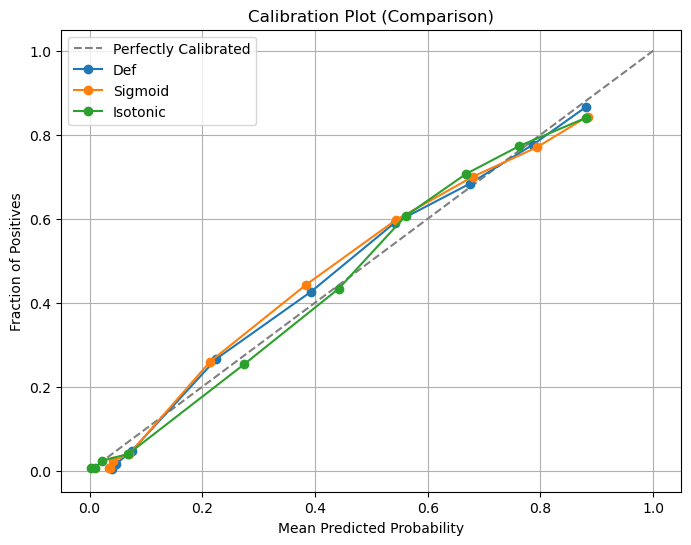

In [14]:
stacking_model.fit(X_train[columns], y_train)
y_prob = stacking_model.predict_proba(X_test[columns])[:,1]
brier_def = brier_score_loss(y_test, y_prob)
print(f"Brier Score (Def): {brier_def:.4f}")

rf_sigmoid = CalibratedClassifierCV(stacking_model, method='sigmoid', cv=skf, n_jobs=-1)
rf_sigmoid.fit(X_train, y_train)
y_prob_sigmoid = rf_sigmoid.predict_proba(X_test)[:,1]
brier_sigmoid = brier_score_loss(y_test, y_prob_sigmoid)
print(f"Brier Score (Sigmoid): {brier_sigmoid:.4f}")

rf_isotonic = CalibratedClassifierCV(stacking_model, method='isotonic', cv=skf, n_jobs=-1)
rf_isotonic.fit(X_train, y_train)
y_prob_isotonic = rf_isotonic.predict_proba(X_test)[:,1]
brier_isotonic = brier_score_loss(y_test, y_prob_isotonic)
print(f"Brier Score (Isotonic): {brier_isotonic:.4f}")

plot_calibration_curve(
    y_test,
    [y_prob, y_prob_sigmoid, y_prob_isotonic],
    ['Def', 'Sigmoid', 'Isotonic'],
    'Calibration Plot (Comparison)'
)

In [15]:
print('ROC-AUC (def)     ', round(roc_auc_score(y_test, y_prob),5))
print('ROC-AUC (sigmoid) ', round(roc_auc_score(y_test, y_prob_sigmoid),5))
print('ROC-AUC (isotonic)', round(roc_auc_score(y_test, y_prob_isotonic),5))

ROC-AUC (def)      0.89455
ROC-AUC (sigmoid)  0.8924
ROC-AUC (isotonic) 0.89211


хоть тут не видно, но **isotonic** показал мне лучшие результаты в Kaggle и Colab, потому стал пользоваться именно им